# Libraries

In [ ]:
# Installing required libraries
!pip install facenet_pytorch

In [ ]:
# Importing required libraries
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics.pairwise import cosine_similarity
from torch.utils.data import DataLoader, Dataset
from albumentations.pytorch import ToTensorV2
import torchvision.models as models
from torchvision import transforms
from facenet_pytorch import MTCNN
from IPython.display import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt
from google.colab import drive
import torch.optim as optim
import albumentations as A
import torch.nn as nn
from PIL import Image
import numpy as np
import kagglehub
import random
import torch
import math
import os

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.3 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
# Mount colab
drive.mount('/content/drive')

Mounted at /content/drive


# Loading dataset

In [ ]:
# Downloading LFW dataset from Kaggle
path = kagglehub.dataset_download('jessicali9530/lfw-dataset')

100%|██████████| 112M/112M [00:05<00:00, 23.5MB/s]

Extracting files...


# Preprocessing

In [ ]:
def read_images_from_path(directory):
    return [
        os.path.join(directory, img) for img in os.listdir(directory)
        if img.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]

def detect_and_crop_face(image_path):
    img = Image.open(image_path).convert("RGB")
    box, _ = mtcnn.detect(img)

    if box is None:
        print(f"No face detected in: {image_path}")
        return None

    x1, y1, x2, y2 = map(int, box[0])  # Convert coordinates to int
    cropped_face = img.crop((x1, y1, x2, y2))
    return cropped_face

def create_triplets(people_folders, deep_funneled_path, num_triplets):
    triplets = []

    for _ in range(num_triplets):
        anchor_person = random.choice(people_folders)
        anchor_folder = os.path.join(deep_funneled_path, anchor_person)
        anchor_images = read_images_from_path(anchor_folder)

        # Crop faces from images
        anchor_images = [detect_and_crop_face(img) for img in anchor_images if detect_and_crop_face(img) is not None]

        if len(anchor_images) < 2:
            continue  # Need at least two images for anchor and positive

        anchor, positive = random.sample(anchor_images, 2)

        negative_person = random.choice(people_folders)
        while negative_person == anchor_person:
            negative_person = random.choice(people_folders)

        negative_folder = os.path.join(deep_funneled_path, negative_person)
        negative_images = read_images_from_path(negative_folder)

        negative_images = [detect_and_crop_face(img) for img in negative_images if detect_and_crop_face(img) is not None]

        if len(negative_images) == 0:
            continue  # Skip if no negative images are available

        negative = random.choice(negative_images)

        triplets.append((anchor, positive, negative))

    return triplets

def prepare_triplets(triplets, transform, is_albumentations=True):
    prepared_triplets = []

    for (anchor, positive, negative) in triplets:
        if isinstance(anchor, torch.Tensor):
            anchor = transforms.ToPILImage()(anchor)
        if isinstance(positive, torch.Tensor):
            positive = transforms.ToPILImage()(positive)
        if isinstance(negative, torch.Tensor):
            negative = transforms.ToPILImage()(negative)

        if is_albumentations:
            anchor = np.array(anchor)
            positive = np.array(positive)
            negative = np.array(negative)

            anchor = transform(image=anchor)["image"]
            positive = transform(image=positive)["image"]
            negative = transform(image=negative)["image"]

        else:
            anchor = transform(anchor)
            positive = transform(positive)
            negative = transform(negative)

        prepared_triplets.append((anchor, positive, negative))

    return prepared_triplets

def normalize_embeddings(embeddings):
    return embeddings / torch.norm(embeddings, dim=1, keepdim=True)

In [ ]:
deep_funneled_path = '/root/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4/lfw-deepfunneled/lfw-deepfunneled'
people_folders = [f for f in os.listdir(deep_funneled_path) if os.path.isdir(os.path.join(deep_funneled_path, f))]

random.shuffle(people_folders)
split_idx = int(0.8 * len(people_folders))
train_people = people_folders[:split_idx]
test_people = people_folders[split_idx:]

train_triplets = create_triplets(train_people, deep_funneled_path, num_triplets=8000)
test_triplets = create_triplets(test_people, deep_funneled_path, num_triplets=2000)

train_transform = A.Compose([
    A.Resize(224, 224),
    A.RandomResizedCrop(190, 190),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=20),
    A.ColorJitter(brightness=0.2, contrast=0.2),
    A.GaussianBlur(blur_limit=(3,5), p=0.2),
    A.ToGray(p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(190),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_triplets = prepare_triplets(train_triplets, train_transform, is_albumentations=True)
test_triplets = prepare_triplets(test_triplets, test_transform, is_albumentations=False)

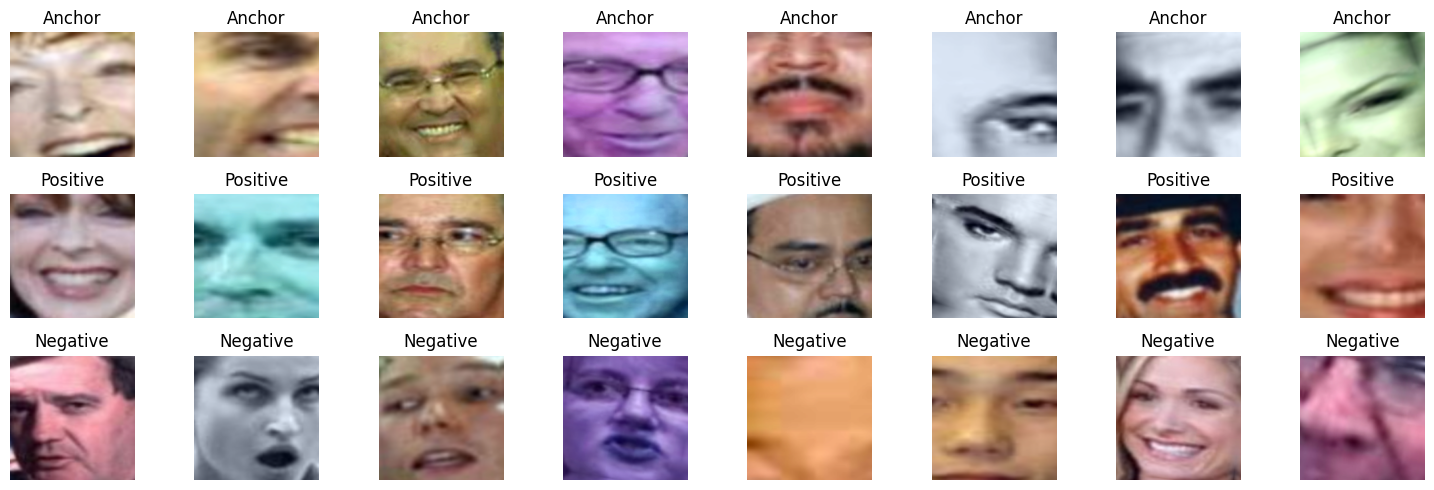

In [ ]:
def visualize_triplets(triplets, num_triplets=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_triplets):
        anchor, positive, negative = triplets[i]

        # Convert tensors back to images for visualization
        def normalize(img):
            img = img.permute(1, 2, 0).numpy()                  # Convert from (C, H, W) to (H, W, C)
            return (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]

        anchor = normalize(anchor)
        positive = normalize(positive)
        negative = normalize(negative)

        plt.subplot(3, num_triplets, i + 1)
        plt.imshow(anchor)
        plt.title("Anchor")
        plt.axis("off")

        plt.subplot(3, num_triplets, i + 1 + num_triplets)
        plt.imshow(positive)
        plt.title("Positive")
        plt.axis("off")

        plt.subplot(3, num_triplets, i + 1 + 2 * num_triplets)
        plt.imshow(negative)
        plt.title("Negative")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_triplets(train_triplets, num_triplets=8)

# Model (Transfer Learning with Siamese Network)

In [ ]:
class MyModel(nn.Module):
    def __init__(self, embedding_dim=128):
        super(MyModel, self).__init__()
        self.base_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        for param in self.base_model.parameters():
            param.requires_grad = False
        for param in self.base_model.features[-5:].parameters():
            param.requires_grad = True
        self.base_model.classifier = nn.Identity()  # Remove the classifier head
        self.batch_norm = nn.BatchNorm1d(1280)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc_embedding = nn.Linear(1280, embedding_dim)
        self.dropout = nn.Dropout(p=0.4)

    def forward_one(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.batch_norm(x)
        x = self.fc_embedding(x)
        x = self.dropout(x)
        return F.normalize(x, p=2, dim=1)  # Normalize embeddings

    def forward(self, input1, input2):
        embed1 = self.forward_one(input1)
        embed2 = self.forward_one(input2)
        return embed1, embed2

model = MyModel()

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 86.1MB/s]


# Loss Function

In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = (anchor - positive).pow(2).sum(1)  # Euclidean distance
        distance_negative = (anchor - negative).pow(2).sum(1)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

class TripletDataset(Dataset):
    def __init__(self, triplets, transform=None, is_albumentations=True):
        self.triplets = triplets
        self.transform = transform
        self.is_albumentations = is_albumentations  # Albumentations or Torchvision

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        anchor, positive, negative = self.triplets[idx]

        # Convert to PIL images if they are tensors
        if isinstance(anchor, torch.Tensor):
            anchor = transforms.ToPILImage()(anchor)
        if isinstance(positive, torch.Tensor):
            positive = transforms.ToPILImage()(positive)
        if isinstance(negative, torch.Tensor):
            negative = transforms.ToPILImage()(negative)

        if self.is_albumentations:
            # Convert images to NumPy arrays for Albumentations
            anchor = np.array(anchor)
            positive = np.array(positive)
            negative = np.array(negative)

            anchor = self.transform(image=anchor)["image"]
            positive = self.transform(image=positive)["image"]
            negative = self.transform(image=negative)["image"]
        else:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)

        return anchor, positive, negative

class TripletTestDataset(Dataset):
    def __init__(self, triplets):
        self.triplets = triplets

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        return self.triplets[idx]

# Training

In [ ]:
train_dataset = TripletDataset(train_triplets, transform=train_transform, is_albumentations=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TripletTestDataset(test_triplets)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = TripletLoss(margin=1)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
model = model.to(device)
best_accuracy = 0
epoch_losses = []
epoch_accuracies = []
model_path = "/content/drive/MyDrive/model.pth"

if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, weights_only=False))

In [ ]:
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct_train = 0
    total_train = 0

    for batch_idx, (anchor, positive, negative) in enumerate(train_loader):
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        optimizer.zero_grad()

        anchor_embed = normalize_embeddings(model.forward_one(anchor))
        positive_embed = normalize_embeddings(model.forward_one(positive))
        negative_embed = normalize_embeddings(model.forward_one(negative))

        loss = criterion(anchor_embed, positive_embed, negative_embed)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        pos_dist = torch.norm(anchor_embed - positive_embed, dim=1)
        neg_dist = torch.norm(anchor_embed - negative_embed, dim=1)
        correct_train += (pos_dist < neg_dist).sum().item()
        total_train += anchor.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy_train = correct_train / total_train

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch_idx, (anchor, positive, negative) in enumerate(test_loader):
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            anchor_embed = normalize_embeddings(model.forward_one(anchor))
            positive_embed = normalize_embeddings(model.forward_one(positive))
            negative_embed = normalize_embeddings(model.forward_one(negative))

            loss = criterion(anchor_embed, positive_embed, negative_embed)
            val_loss += loss.item()

            pos_dist = torch.norm(anchor_embed - positive_embed, dim=1)
            neg_dist = torch.norm(anchor_embed - negative_embed, dim=1)
            correct_val += (pos_dist < neg_dist).sum().item()
            total_val += anchor.size(0)

    val_loss /= len(test_loader)
    val_accuracy = correct_val / total_val

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy_train:.4f}, "
          f"Test Loss: {val_loss:.4f}, Test Acc: {val_accuracy:.4f}")

    epoch_losses.append(epoch_loss)
    epoch_accuracies.append(epoch_accuracy_train)

    if val_accuracy > best_accuracy:
        print('Best model saved.')
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), model_path)

Epoch 1/50: Train Loss: 0.9908, Train Acc: 0.5162, Test Loss: 0.8375, Test Acc: 0.6546
Epoch 2/50: Train Loss: 0.9834, Train Acc: 0.5317, Test Loss: 0.8323, Test Acc: 0.6822
Epoch 3/50: Train Loss: 0.9654, Train Acc: 0.5403, Test Loss: 0.8494, Test Acc: 0.6580
Epoch 4/50: Train Loss: 0.9576, Train Acc: 0.5455, Test Loss: 0.8027, Test Acc: 0.7064
Epoch 5/50: Train Loss: 0.9490, Train Acc: 0.5455, Test Loss: 0.7991, Test Acc: 0.7237
Epoch 6/50: Train Loss: 0.9204, Train Acc: 0.5696, Test Loss: 0.7979, Test Acc: 0.7427
Epoch 7/50: Train Loss: 0.9058, Train Acc: 0.5610, Test Loss: 0.7888, Test Acc: 0.7133
Epoch 8/50: Train Loss: 0.8788, Train Acc: 0.5921, Test Loss: 0.7884, Test Acc: 0.7150
Epoch 9/50: Train Loss: 0.8581, Train Acc: 0.6076, Test Loss: 0.7698, Test Acc: 0.7254
Epoch 10/50: Train Loss: 0.8515, Train Acc: 0.6141, Test Loss: 0.7472, Test Acc: 0.7392
Epoch 11/50: Train Loss: 0.8550, Train Acc: 0.5998, Test Loss: 0.7193, Test Acc: 0.7427
Epoch 12/50: Train Loss: 0.8122, Train Ac

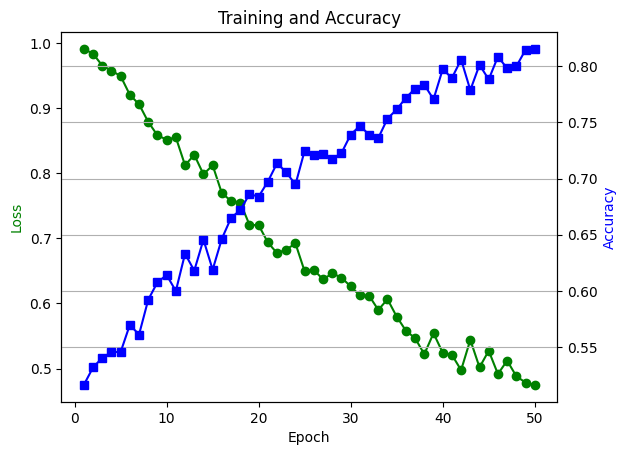

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(range(1, num_epochs + 1), epoch_losses, 'g-', marker='o', label='Loss')
ax2.plot(range(1, num_epochs + 1), epoch_accuracies, 'b-', marker='s', label='Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='g')
ax2.set_ylabel('Accuracy', color='b')
plt.title('Training and Accuracy')
plt.grid()
plt.show()

# Evaluation

In [ ]:
def compute_triplet_embeddings(model, dataloader, device):
    model.eval()
    anchors = []
    positives = []
    negatives = []

    with torch.no_grad():
        for anchor, positive, negative in dataloader:
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            anchor_embed = model.forward_one(anchor)
            positive_embed = model.forward_one(positive)
            negative_embed = model.forward_one(negative)

            anchors.append(anchor_embed.cpu())
            positives.append(positive_embed.cpu())
            negatives.append(negative_embed.cpu())
    anchors = torch.cat(anchors, dim=0)
    positives = torch.cat(positives, dim=0)
    negatives = torch.cat(negatives, dim=0)

    return anchors, positives, negatives

def compute_distances(anchors, positives, negatives):
    anchors = normalize_embeddings(anchors)
    positives = normalize_embeddings(positives)
    negatives = normalize_embeddings(negatives)
    distance_positive = torch.norm(anchors - positives, dim=1)
    distance_negative = torch.norm(anchors - negatives, dim=1)
    return distance_positive, distance_negative

def evaluate_triplets(distance_positive, distance_negative):
    distance_positive = distance_positive.clone().detach()
    distance_negative = distance_negative.clone().detach()

    correct = (distance_positive < distance_negative).float()
    accuracy = correct.mean().item() * 100  # Convert to percentage

    # Labels: 1 for positive pairs, 0 for negative pairs
    y_true = np.concatenate([np.ones_like(distance_positive), np.zeros_like(distance_negative)])
    y_scores = np.concatenate([distance_positive, distance_negative])

    # Compute ROC Curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)

    # Compute EER (Equal Error Rate)
    fnr = 1 - tpr
    eer = fpr[np.nanargmin(np.abs(fpr - fnr))]

    threshold = np.median(y_scores)
    y_pred = (y_scores < threshold).astype(int)

    precision = precision_score(y_true, y_pred, zero_division=1) * 100  # Avoid divide by zero
    recall = recall_score(y_true, y_pred) * 100
    f1 = f1_score(y_true, y_pred) * 100
    roc_auc = roc_auc_score(y_true, y_scores)

    return accuracy, precision, recall, f1, roc_auc, eer

def plot_roc_curve(distance_positive, distance_negative):
    # Ground truth labels: 1 for positive pairs, 0 for negative pairs
    y_true = np.concatenate([np.ones_like(distance_positive), np.zeros_like(distance_negative)])

    # Predicted similarity scores
    y_scores = np.concatenate([distance_positive, distance_negative])

    fpr, tpr, _ = roc_curve(y_true, -y_scores)  # Negate scores since lower distance means more similarity
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Random guess line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

In [ ]:
anchors, positives, negatives = compute_triplet_embeddings(model, test_loader, device)
distance_positive, distance_negative = compute_distances(anchors, positives, negatives)

accuracy, precision, recall, f1, roc_auc, eer = evaluate_triplets(distance_positive, distance_negative)
print(f"Accuracy:         {accuracy:.2f}%")
print(f"Precision:        {precision:.2f}%")
print(f"Recall:           {recall:.2f}%")
print(f"F1-score:         {f1:.2f}%")
print(f"ROC-AUC Score:    {roc_auc:.4f}")
print(f"Equal Error Rate: {eer:.4f}")

Accuracy:         79.00%
Precision:        69.36%
Recall:           69.36%
F1-score:         69.36%
ROC-AUC Score:    0.2208
Equal Error Rate: 0.6936


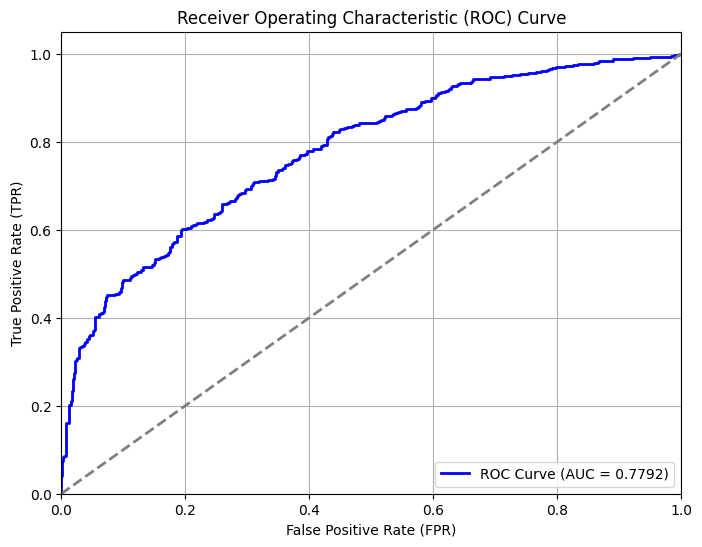

In [ ]:
plot_roc_curve(distance_positive, distance_negative)

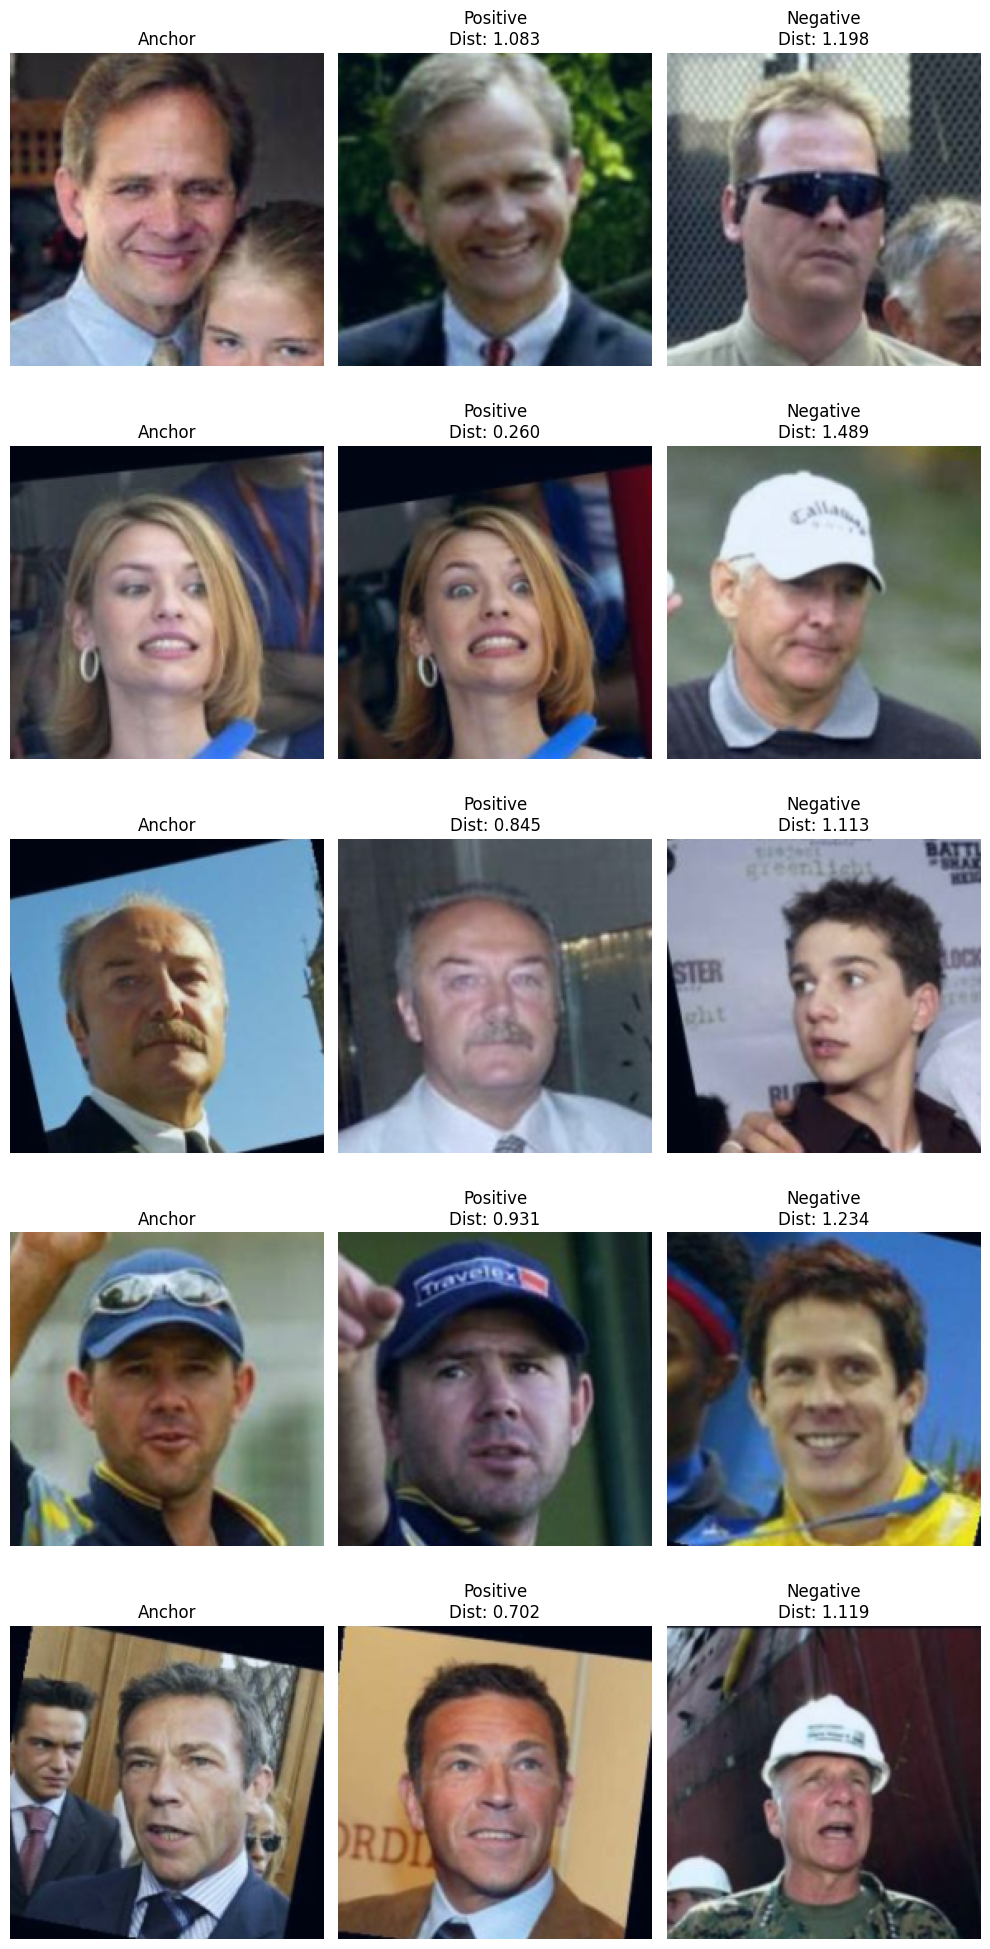

In [ ]:
def visualize_model_predictions(model, test_loader, device, num_samples=5):
    model.eval()

    # Get a batch of test samples
    data_iter = iter(test_loader)
    batch = next(data_iter)

    anchor, positive, negative = batch
    anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

    with torch.no_grad():
        anchor_embed = model.forward_one(anchor)
        positive_embed = model.forward_one(positive)
        negative_embed = model.forward_one(negative)

    # Compute Euclidean distances
    pos_dist = torch.norm(anchor_embed - positive_embed, p=2, dim=1)
    neg_dist = torch.norm(anchor_embed - negative_embed, p=2, dim=1)

    def to_numpy(img):
        img = img.cpu().permute(1, 2, 0).numpy()            # Convert from (C, H, W) to (H, W, C)
        return (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]

    fig, axes = plt.subplots(num_samples, 3, figsize=(10, num_samples * 4))

    for i in range(num_samples):
        anchor_img = to_numpy(anchor[i])
        positive_img = to_numpy(positive[i])
        negative_img = to_numpy(negative[i])

        axes[i, 0].imshow(anchor_img)
        axes[i, 0].set_title(f"Anchor", fontsize=12)
        axes[i, 0].axis("off")

        axes[i, 1].imshow(positive_img)
        axes[i, 1].set_title(f"Positive\nDist: {pos_dist[i]:.3f}", fontsize=12)
        axes[i, 1].axis("off")

        axes[i, 2].imshow(negative_img)
        axes[i, 2].set_title(f"Negative\nDist: {neg_dist[i]:.3f}", fontsize=12)
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

visualize_model_predictions(model, test_loader, device, num_samples=5)

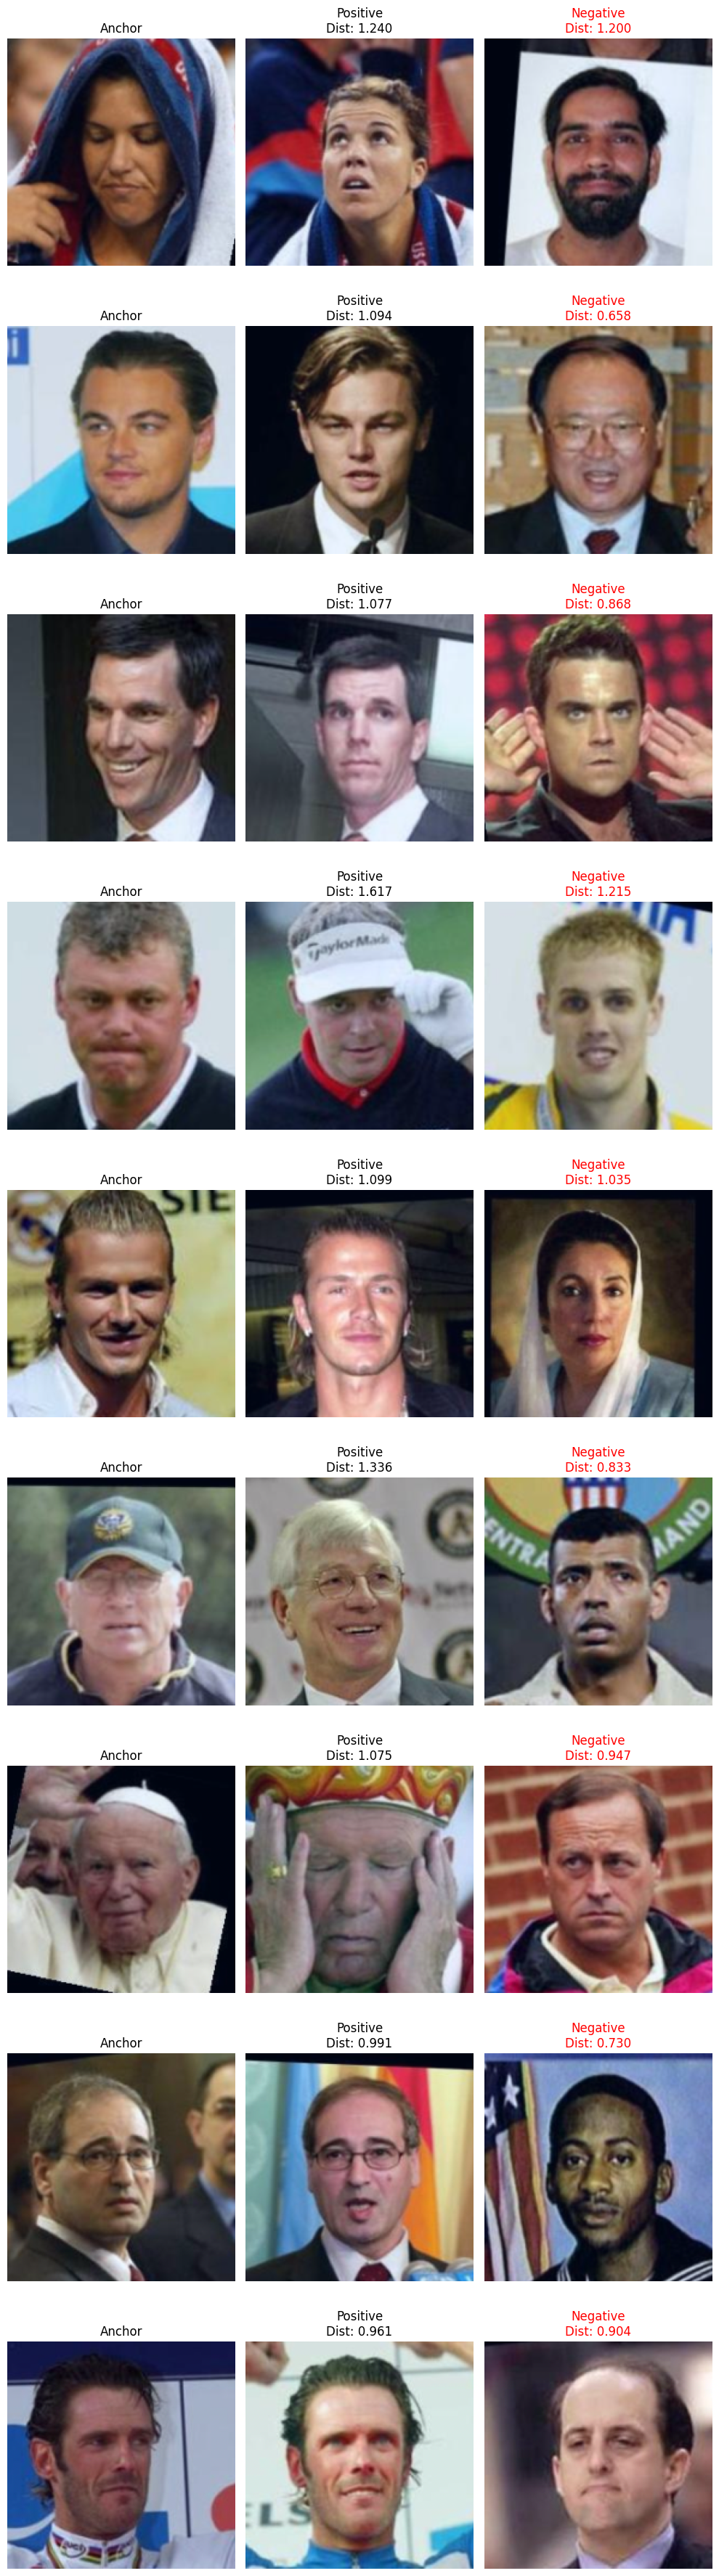

In [ ]:
def visualize_incorrect_predictions(model, test_loader, device, max_samples=5):
    model.eval()
    incorrect_samples = []
    for batch in test_loader:
        anchor, positive, negative = batch
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        with torch.no_grad():
            anchor_embed = model.forward_one(anchor)
            positive_embed = model.forward_one(positive)
            negative_embed = model.forward_one(negative)

        pos_dist = torch.norm(anchor_embed - positive_embed, p=2, dim=1)
        neg_dist = torch.norm(anchor_embed - negative_embed, p=2, dim=1)

        # Identify incorrect cases where neg_dist < pos_dist
        incorrect_mask = neg_dist < pos_dist  # Boolean mask of incorrect predictions

        for i in range(len(anchor)):
            if incorrect_mask[i]:
                incorrect_samples.append((anchor[i], positive[i], negative[i], pos_dist[i].item(), neg_dist[i].item()))

        if len(incorrect_samples) >= max_samples:
            break

    fig, axes = plt.subplots(len(incorrect_samples), 3, figsize=(10, len(incorrect_samples) * 4))

    def to_numpy(img):
        img = img.cpu().permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
        return (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]

    for i, (anchor, positive, negative, pos_dist, neg_dist) in enumerate(incorrect_samples):
        anchor_img = to_numpy(anchor)
        positive_img = to_numpy(positive)
        negative_img = to_numpy(negative)

        axes[i, 0].imshow(anchor_img)
        axes[i, 0].set_title(f"Anchor", fontsize=12)
        axes[i, 0].axis("off")

        axes[i, 1].imshow(positive_img)
        axes[i, 1].set_title(f"Positive\nDist: {pos_dist:.3f}", fontsize=12)
        axes[i, 1].axis("off")

        axes[i, 2].imshow(negative_img)
        axes[i, 2].set_title(f"Negative\nDist: {neg_dist:.3f}", fontsize=12, color='red')
        axes[i, 2].axis("off")
    plt.tight_layout()
    plt.show()

visualize_incorrect_predictions(model, test_loader, device)

In [ ]:
def create_validation_set(test_triplets, num_pairs=1000):
    validation_pairs = []

    # Create same-person pairs
    for _ in range(num_pairs // 2):                            # Half will be same-person pairs
        person_triplet = random.choice(test_triplets)          # Random triplet
        anchor, positive, _ = person_triplet                   # Pick anchor & positive (same person)
        validation_pairs.append((anchor, positive, 1))         # Label = 1

    # Create different-person pairs
    people_triplets = random.sample(test_triplets, num_pairs)  # Select different triplets
    for i in range(num_pairs // 2):
        anchor, _, _ = people_triplets[i]                      # Pick an anchor from one person
        _, _, negative = people_triplets[-(i + 1)]             # Pick a negative from another person
        validation_pairs.append((anchor, negative, 0))         # Label = 0

    random.shuffle(validation_pairs)                           # Shuffle dataset
    return validation_pairs

def find_best_thresholds(validation_pairs, model):
    model.eval()
    distances_euclidean = []
    distances_cosine = []
    labels = []

    with torch.no_grad():
        for (img1, img2, label) in validation_pairs:
            img1, img2 = img1.to(device), img2.to(device)
            emb1, emb2 = model.forward_one(img1.unsqueeze(0)), model.forward_one(img2.unsqueeze(0))

            euclidean_dist = torch.norm(emb1 - emb2, p=2).item()
            cosine_dist = 1 - torch.nn.functional.cosine_similarity(emb1, emb2).item()

            distances_euclidean.append(euclidean_dist)
            distances_cosine.append(cosine_dist)
            labels.append(label)

    distances_euclidean = np.array(distances_euclidean)
    distances_cosine = np.array(distances_cosine)
    labels = np.array(labels)

    def best_threshold(distances, labels):
        _, _, thresholds = roc_curve(labels, distances)
        return np.median(thresholds)

    best_euclidean_threshold = best_threshold(distances_euclidean, labels)
    best_cosine_threshold = best_threshold(distances_cosine, labels)

    print(f"Best Euclidean Threshold: {best_euclidean_threshold:.3f}")
    print(f"Best Cosine Threshold: {best_cosine_threshold:.3f}")

validation_pairs = create_validation_set(test_triplets)
find_best_thresholds(validation_pairs, model)

Best Euclidean Threshold: 0.957
Best Cosine Threshold: 0.457


# Test

In [ ]:
def get_embedding(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to("cpu")
    with torch.no_grad():
        embedding = model.forward_one(image).cpu().numpy().flatten()
    return embedding

In [ ]:
TEST_SET_PATH = '/content/drive/MyDrive/ML-Project-Vision-Data/register'
OUTPUT_FOLDER = '/content/drive/MyDrive/cropped_faces'
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

model = MyModel().to('cpu')
model.load_state_dict(torch.load("/content/drive/MyDrive/model.pth", map_location=torch.device('cpu')))
model.eval()
mtcnn = MTCNN(keep_all=False, device='cpu')

for person_name in os.listdir(TEST_SET_PATH):
    person_path = os.path.join(TEST_SET_PATH, person_name)

    if not os.path.isdir(person_path):
        continue

    output_person_folder = os.path.join(OUTPUT_FOLDER, person_name)
    os.makedirs(output_person_folder, exist_ok=True)

    train_imgs = read_images_from_path(person_path)

    for img_path in train_imgs:
        cropped_face = detect_and_crop_face(img_path)
        if cropped_face:
            img_name = os.path.basename(img_path)
            save_path = os.path.join(output_person_folder, img_name)
            cropped_face.save(save_path)

embeddings_dict = {}
for person_name in os.listdir(OUTPUT_FOLDER):
    cropped_person_folder = os.path.join(OUTPUT_FOLDER, person_name)

    if not os.path.isdir(cropped_person_folder):
        continue

    cropped_imgs = read_images_from_path(cropped_person_folder)
    train_embeddings = []

    for img_path in cropped_imgs:
        embedding = get_embedding(img_path)
        if embedding is not None:
            train_embeddings.append(embedding)

    embeddings_dict[person_name] = np.mean(train_embeddings, axis=0)

In [ ]:
VERIFY_SET_PATH = '/content/drive/MyDrive/ML-Project-Vision-Data/Test'
test_images = []
true_labels = []

for person_name in os.listdir(VERIFY_SET_PATH):
    person_path = os.path.join(VERIFY_SET_PATH, person_name)
    if os.path.isdir(person_path):
        image_files = read_images_from_path(person_path)
        if len(image_files) < 1:
            continue

        for img_path in image_files:
            cropped_face = detect_and_crop_face(img_path)  # Detect and crop face
            if cropped_face:
                test_images.append(cropped_face)           # Store cropped face instead of original image
                true_labels.append(person_name)            # Store the corresponding label

total_tests = len(test_images)
correct = 0
predicted_names = []
similarity_scores = []

cols = min(total_tests, 5)  # Max 5 per row
rows = math.ceil(total_tests / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
axes = axes.flatten() if total_tests > 1 else [axes]

for i, (cropped_face, true_label) in enumerate(zip(test_images, true_labels)):
    temp_path = f"/tmp/temp_cropped_{i}.jpg"
    cropped_face.save(temp_path)
    test_embedding = get_embedding(temp_path)
    best_match = None
    best_score = -1
    for person_name, stored_embedding in embeddings_dict.items():
        similarity = cosine_similarity([test_embedding], [stored_embedding])[0][0]
        if similarity > best_score:
            best_score = similarity
            best_match = person_name

    if best_score < 0.7:
        best_match = "Unknown"

    predicted_names.append(best_match)
    similarity_scores.append(best_score)
    if best_match == true_label:
        correct += 1

    axes[i].imshow(cropped_face)
    axes[i].axis("off")
    axes[i].set_title(f"True: {true_label}\nPred: {best_match}\n({best_score:.2f})", fontsize=12)

accuracy = (correct / total_tests) * 100
print(f"Accuracy: {accuracy:.2f}% on {total_tests} test images\n")
plt.tight_layout()
plt.show()